In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import sklearn as skl
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score, normalized_mutual_info_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import scipy.cluster.hierarchy as shc
from sklearn.neighbors import NearestNeighbors
import time
import gdown
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

dados_sem_outliers = pd.read_csv("SGP_dados_regressão_v3_qc_leq_1.csv")
# Volume de dados
dados_sem_outliers.shape
# Estatística descritiva básica
dados_sem_outliers.describe()
# Exemplo: alvo contínuo com valores negativos
y = dados_sem_outliers['Scattering_Eff']  # seu vetor alvo

# Calculamos o shift para deixar os valores do alvo positivos
min_y = y.min()
eps = 1e-6  # pequeno deslocamento de segurança
shift = -min_y + eps  # garante todos positivos

# Aplicando a transformação log(alvo+1) após fazer shift
y_log = np.log1p(y + shift)
from sklearn.model_selection import train_test_split

# Separação de variáveis preditoras e alvo
X = dados_sem_outliers.drop(['Scattering_Eff'], axis=1) # Características
y = dados_sem_outliers['Scattering_Eff'] # Alvo

y_bins = pd.qcut(y_log, q=25, labels=False, duplicates='drop')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y_bins)
# Escalonando os preditores X
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

# Redes Neurais

In [ ]:
from sklearn.model_selection import train_test_split

# Separação de variáveis preditoras e alvo
X = dados_sem_outliers.drop(['Scattering_Eff'], axis=1) # Preditores
y = dados_sem_outliers['Scattering_Eff'] # Alvo


# Calculamos o shift para deixar os valores do alvo positivos
min_y = y.min()
eps = 1e-6  # pequeno deslocamento de segurança
shift = -min_y + eps  # garante todos positivos

# Aplicando a transformação log(alvo+1) após fazer shift
y_log = np.log1p(y + shift)

y_bins = pd.qcut(y_log, q=25, labels=False, duplicates='drop')

# divisão do dataset em treino, teste e validação.
# as variáveis abaixo determinam as frações
train_ratio = 0.65
validation_ratio = 0.15
test_ratio = 0.2
random_state = 42

# Primeiro split: separa treino do restante (validação + teste)
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=1 - train_ratio, stratify = y_bins, random_state = random_state)

# Calculamos o shift para deixar os valores do alvo de `y_rem` positivos
min_y_rem = y_rem.min()
eps = 1e-6
shift_rem = -min_y_rem + eps
y_log_rem = np.log1p(y_rem + shift_rem)

# Cria os bins para `y_rem` para estratificação do segundo split
y_bins_rem = pd.qcut(y_log_rem, q=18, labels=False, duplicates='drop')

# Segundo split: divide o restante (`X_rem`, `y_rem`) em validação e teste
test_size_for_second_split = test_ratio / (test_ratio + validation_ratio)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=test_size_for_second_split, random_state = random_state, stratify = y_bins_rem)

In [ ]:
# Escalonando os preditores X
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as B
from tensorflow.keras.optimizers import Adam

def r_squared(y_t, y_p):
    SS_res = B.sum(B.square(y_t - y_p))
    SS_tot = B.sum(B.square(y_t - B.mean(y_t)))
    # Adiciona B.epsilon() para evitar divisão por zero
    return (1 - SS_res/(SS_tot + B.epsilon()))

# Construção do modelo no Keras
model = keras.Sequential([
    layers.Input(shape=(X.shape[1],)),
    layers.Dense(700, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(350, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(350, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])

model.compile(Adam(learning_rate=0.0005),
              loss='mean_squared_error',
              metrics=[r_squared])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 700)            │         8,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 350)            │       245,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 350)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 350)            │       122,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 350)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           351 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 376,951 (1.44 MB)

 Trainable params: 376,951 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# treinamento da rede
# verbose = 0, 1 ou 2 indica a quantidade de print
# aqui são usadas duas estratégias de saída

early_stop = keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor="val_loss")
reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=6, verbose=1, monitor="val_loss")

history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=500,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 2.3619 - r_squared: -2.8620 - val_loss: 0.5613 - val_r_squared: 0.0737 - learning_rate: 5.0000e-04
Epoch 2/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6618 - r_squared: -0.0269 - val_loss: 0.5279 - val_r_squared: 0.1250 - learning_rate: 5.0000e-04
Epoch 3/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.5937 - r_squared: 0.0205 - val_loss: 0.5193 - val_r_squared: 0.1430 - learning_rate: 5.0000e-04
Epoch 4/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.5639 - r_squared: 0.0802 - val_loss: 0.4925 - val_r_squared: 0.1820 - learning_rate: 5.0000e-04
Epoch 5/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.5708 - r_squared: 0.1013 - val_loss: 0.4729 - val_r_squared: 0.2204 - learning_rate: 5.0000e-04
Epoch 6/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.5581 - r_squared: 0.1356 - val_loss: 0.4637 - val_r_squared: 0.2424 - learning_rate: 5.0000e-04
Epoch 7/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/ste

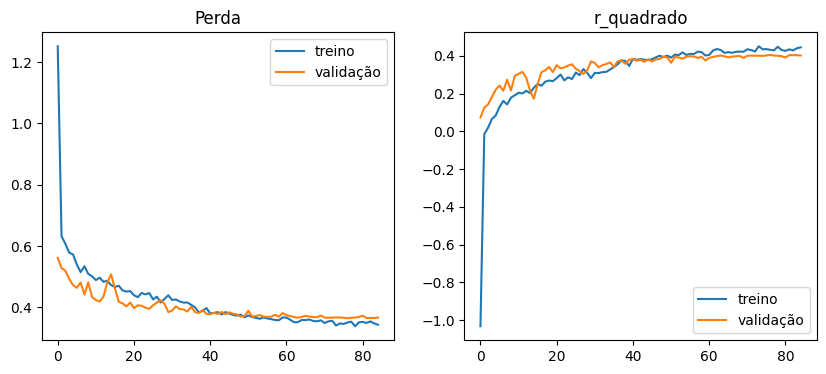

In [ ]:
# faz figura da perda e do r^2 para cada época

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='validação')
plt.title('Perda')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['r_squared'], label='treino')
plt.plot(history.history['val_r_squared'], label='validação')
plt.title('r_quadrado')
plt.legend()
plt.show()

In [ ]:
y_pred_test = model.predict(X_test_s) # predição para o conjunto de teste
y_pred_test = y_pred_test.reshape(1,len(y_pred_test))
r2_score(y_test, y_pred_test[0,:])

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


0.41900684580922953

In [ ]:
# treinamento da rede
# verbose = 0, 1 ou 2 indica a quantidade de print
history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=200,
    verbose=1
)

Epoch 1/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3488 - r_squared: 0.4004 - val_loss: 0.3674 - val_r_squared: 0.3768
Epoch 2/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3368 - r_squared: 0.4361 - val_loss: 0.3667 - val_r_squared: 0.3783
Epoch 3/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3459 - r_squared: 0.4311 - val_loss: 0.3662 - val_r_squared: 0.3784
Epoch 4/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3578 - r_squared: 0.4086 - val_loss: 0.3667 - val_r_squared: 0.3777
Epoch 5/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.3547 - r_squared: 0.4211 - val_loss: 0.3667 - val_r_squared: 0.3778
Epoch 6/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.3454 - r_squared: 0.4128 - val_loss: 0.3667 - val_r_squared: 0.3778
Epoch 7/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.3479 - r_squared: 0.4145 - val_loss: 0.3664 - val_r_squared: 0.3785
Epoch 8/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3376 - r_squ

KeyboardInterrupt: 

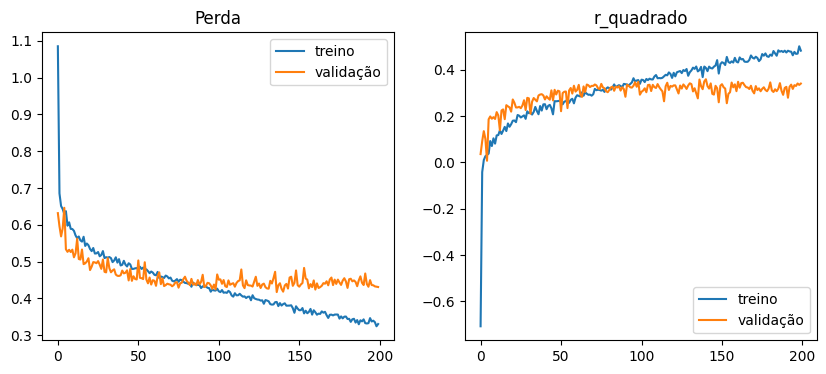

In [ ]:
# faz figura da perda e do r^2 para cada época

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='validação')
plt.title('Perda')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['r_squared'], label='treino')
plt.plot(history.history['val_r_squared'], label='validação')
plt.title('r_quadrado')
plt.legend()
plt.show()

In [ ]:
y_pred_test = model.predict(X_test_s) # predição para o conjunto de teste
y_pred_test = y_pred_test.reshape(1,len(y_pred_test))
r2_score(y_test, y_pred_test[0,:])

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


0.3837977774367064

## teste 3

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as B
from tensorflow.keras.optimizers import Adam

def r_squared(y_t, y_p):
    SS_res = B.sum(B.square(y_t - y_p))
    SS_tot = B.sum(B.square(y_t - B.mean(y_t)))
    # Adiciona B.epsilon() para evitar divisão por zero
    return (1 - SS_res/(SS_tot + B.epsilon()))

# Construção do modelo no Keras
model = keras.Sequential([
    layers.Input(shape=(X.shape[1],)),
    layers.Dense(500, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(250, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(250, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])

model.compile(Adam(learning_rate=0.0005),
              loss='mean_squared_error',
              metrics=[r_squared])

model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_82 (Dense)                │ (None, 500)            │         6,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 250)            │       125,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 250)            │        62,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 1)              │           251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 194,251 (758.79 KB)

 Trainable params: 194,251 (758.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# treinamento da rede
# verbose = 0, 1 ou 2 indica a quantidade de print
# aqui são usadas duas estratégias de saída

early_stop = keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor="val_loss")
reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=6, verbose=1, monitor="val_loss")

history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=500,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 2.7866 - r_squared: -3.1738 - val_loss: 0.6494 - val_r_squared: 0.0296 - learning_rate: 5.0000e-04
Epoch 2/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7105 - r_squared: -0.0716 - val_loss: 0.6170 - val_r_squared: 0.0758 - learning_rate: 5.0000e-04
Epoch 3/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7241 - r_squared: -0.0557 - val_loss: 0.6569 - val_r_squared: 0.0200 - learning_rate: 5.0000e-04
Epoch 4/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6799 - r_squared: -0.0378 - val_loss: 0.5833 - val_r_squared: 0.1263 - learning_rate: 5.0000e-04
Epoch 5/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6636 - r_squared: 0.0039 - val_loss: 0.5844 - val_r_squared: 0.1272 - learning_rate: 5.0000e-04
Epoch 6/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6518 - r_squared: 0.0397 - val_loss: 0.6366 - val_r_squared: 0.0512 - learning_rate: 5.0000e-04
Epoch 7/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - 

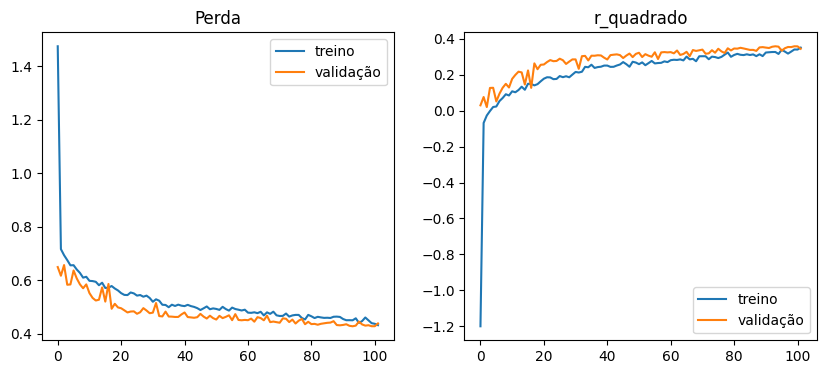

In [ ]:
# faz figura da perda e do r^2 para cada época

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='validação')
plt.title('Perda')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['r_squared'], label='treino')
plt.plot(history.history['val_r_squared'], label='validação')
plt.title('r_quadrado')
plt.legend()
plt.show()

In [ ]:
y_pred_test = model.predict(X_test_s) # predição para o conjunto de teste
y_pred_test = y_pred_test.reshape(1,len(y_pred_test))
r2_score(y_test, y_pred_test[0,:])

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


0.354814945869939

In [ ]:
# treinamento da rede
# verbose = 0, 1 ou 2 indica a quantidade de print
history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs = 200,
    verbose=1
)

Epoch 1/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2.0542 - r_squared: -2.1762 - val_loss: 0.6318 - val_r_squared: 0.0384
Epoch 2/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6901 - r_squared: -0.0859 - val_loss: 0.6280 - val_r_squared: 0.0429
Epoch 3/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6529 - r_squared: -0.0118 - val_loss: 0.5904 - val_r_squared: 0.0959
Epoch 4/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6706 - r_squared: -0.0365 - val_loss: 0.5698 - val_r_squared: 0.1319
Epoch 5/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6545 - r_squared: 0.0130 - val_loss: 0.5827 - val_r_squared: 0.1093
Epoch 6/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.6332 - r_squared: 0.0327 - val_loss: 0.5543 - val_r_squared: 0.1547
Epoch 7/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6108 - r_squared: 0.0494 - val_loss: 0.5422 - val_r_squared: 0.1741
Epoch 8/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6082 - r_squar

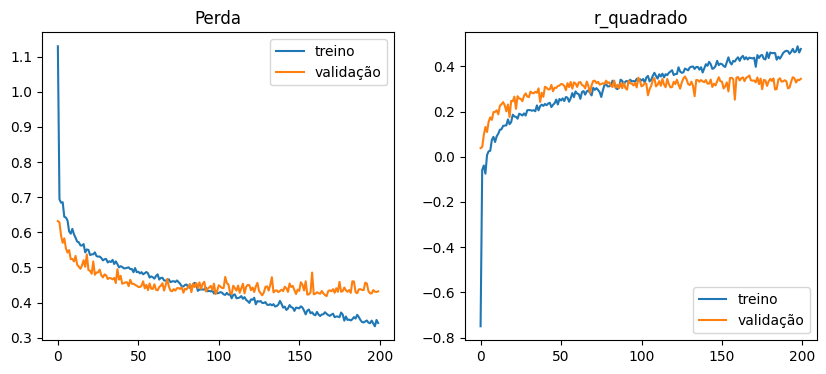

In [ ]:
# faz figura da perda e do r^2 para cada época

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='validação')
plt.title('Perda')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['r_squared'], label='treino')
plt.plot(history.history['val_r_squared'], label='validação')
plt.title('r_quadrado')
plt.legend()
plt.show()

In [ ]:
y_pred_test = model.predict(X_test_s) # predição para o conjunto de teste
y_pred_test = y_pred_test.reshape(1,len(y_pred_test))
r2_score(y_test, y_pred_test[0,:])

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


0.3818012857080022

## teste 2

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as B

def r_squared(y_t, y_p):
    SS_res = B.sum(B.square(y_t - y_p))
    SS_tot = B.sum(B.square(y_t - B.mean(y_t)))
    # Adiciona B.epsilon() para evitar divisão por zero
    return (1 - SS_res/(SS_tot + B.epsilon()))

# Construção do modelo no Keras
model = keras.Sequential([
    layers.Input(shape=(X.shape[1],)),

    layers.Dense(200, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(150, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(100, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[r_squared])

model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_78 (Dense)                │ (None, 200)            │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,751 (186.53 KB)

 Trainable params: 47,751 (186.53 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# treinamento da rede
# verbose = 0, 1 ou 2 indica a quantidade de print
# aqui são usadas duas estratégias de saída

early_stop = keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor="val_loss")
reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=6, verbose=1, monitor="val_loss")

history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=500,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.1193 - r_squared: -3.8758 - val_loss: 0.6484 - val_r_squared: 0.0321 - learning_rate: 0.0010
Epoch 2/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8917 - r_squared: -0.3244 - val_loss: 0.6065 - val_r_squared: 0.0903 - learning_rate: 0.0010
Epoch 3/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7611 - r_squared: -0.1361 - val_loss: 0.6079 - val_r_squared: 0.0902 - learning_rate: 0.0010
Epoch 4/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7373 - r_squared: -0.0841 - val_loss: 0.5791 - val_r_squared: 0.1318 - learning_rate: 0.0010
Epoch 5/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7374 - r_squared: -0.1068 - val_loss: 0.5846 - val_r_squared: 0.1269 - learning_rate: 0.0010
Epoch 6/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7393 - r_squared: -0.0809 - val_loss: 0.5978 - val_r_squared: 0.1085 - learning_rate: 0.0010
Epoch 7/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6676 - r_square

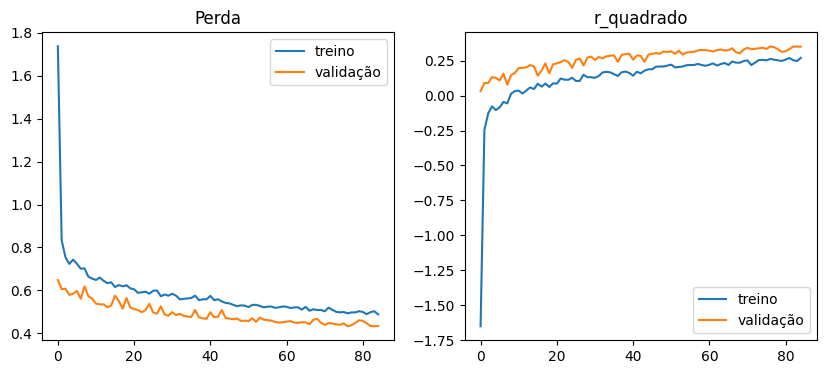

In [ ]:
# faz figura da perda e do r^2 para cada época

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='validação')
plt.title('Perda')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['r_squared'], label='treino')
plt.plot(history.history['val_r_squared'], label='validação')
plt.title('r_quadrado')
plt.legend()
plt.show()

In [ ]:
y_pred_test = model.predict(X_test_s) # predição para o conjunto de teste
y_pred_test = y_pred_test.reshape(1,len(y_pred_test))
r2_score(y_test, y_pred_test[0,:])

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


0.33602621040951164

In [ ]:
# treinamento da rede
# verbose = 0, 1 ou 2 indica a quantidade de print
history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=200,
    verbose=1
)

Epoch 1/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2.0973 - r_squared: -2.0074 - val_loss: 0.6196 - val_r_squared: 0.0579
Epoch 2/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7943 - r_squared: -0.1783 - val_loss: 0.7386 - val_r_squared: -0.1341
Epoch 3/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7522 - r_squared: -0.1487 - val_loss: 0.5914 - val_r_squared: 0.0977
Epoch 4/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7147 - r_squared: -0.1007 - val_loss: 0.5909 - val_r_squared: 0.0999
Epoch 5/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6826 - r_squared: -0.0586 - val_loss: 0.5675 - val_r_squared: 0.1343
Epoch 6/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6997 - r_squared: -0.0832 - val_loss: 0.5757 - val_r_squared: 0.1253
Epoch 7/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6665 - r_squared: -0.0306 - val_loss: 0.6187 - val_r_squared: 0.0536
Epoch 8/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6378 - r_squ

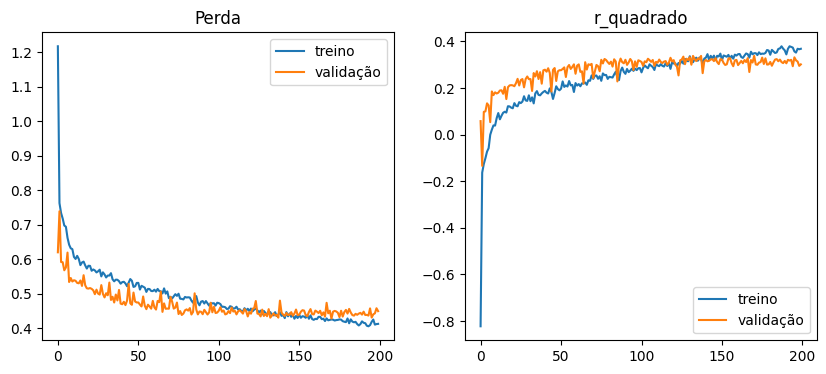

In [ ]:
# faz figura da perda e do r^2 para cada época

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='validação')
plt.title('Perda')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['r_squared'], label='treino')
plt.plot(history.history['val_r_squared'], label='validação')
plt.title('r_quadrado')
plt.legend()
plt.show()

In [ ]:
y_pred_test = model.predict(X_test_s) # predição para o conjunto de teste
y_pred_test = y_pred_test.reshape(1,len(y_pred_test))
r2_score(y_test, y_pred_test[0,:])

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


0.36220999055374314

## USAR ESSE!!! verificando melhor resultado até agora

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as B

def r_squared(y_t, y_p):
    SS_res = B.sum(B.square(y_t - y_p))
    SS_tot = B.sum(B.square(y_t - B.mean(y_t)))
    # Adiciona B.epsilon() para evitar divisão por zero
    return (1 - SS_res/(SS_tot + B.epsilon()))

# Construção do modelo no Keras
model = keras.Sequential([
    layers.Input(shape=(X.shape[1],)),

    layers.Dense(150, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(75, activation='relu'),
    layers.Dropout(0.3),
    #layers.Dense(700, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[r_squared])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 150)            │         1,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,201 (51.57 KB)

 Trainable params: 13,201 (51.57 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# treinamento da rede
# verbose = 0, 1 ou 2 indica a quantidade de print
history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=300,
    verbose=1
)

Epoch 1/300
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.3581 - r_squared: -2.8127 - val_loss: 0.5834 - val_r_squared: 0.0290
Epoch 2/300
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6867 - r_squared: -0.1787 - val_loss: 0.5366 - val_r_squared: 0.1004
Epoch 3/300
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6680 - r_squared: -0.1366 - val_loss: 0.5258 - val_r_squared: 0.1202
Epoch 4/300
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6226 - r_squared: -0.0747 - val_loss: 0.5113 - val_r_squared: 0.1427
Epoch 5/300
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6220 - r_squared: -0.0629 - val_loss: 0.4982 - val_r_squared: 0.1620
Epoch 6/300
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6162 - r_squared: -0.0260 - val_loss: 0.4935 - val_r_squared: 0.1722
Epoch 7/300
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6069 - r_squared: -0.0657 - val_loss: 0.5033 - val_r_squared: 0.1598
Epoch 8/300
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6494 - r_squa

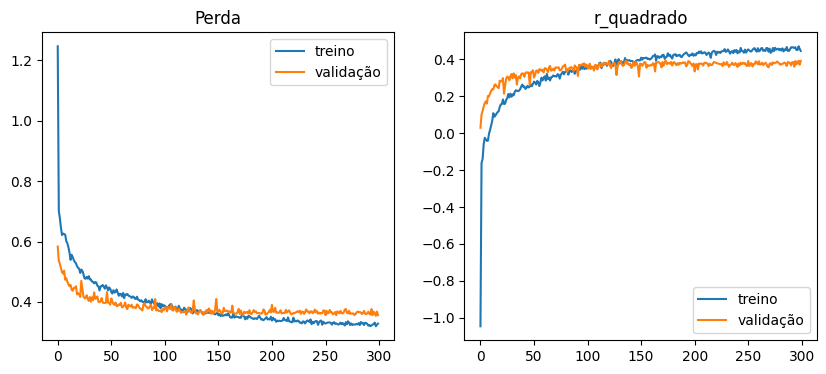

In [ ]:
# faz figura da perda e do r^2 para cada época

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='validação')
plt.title('Perda')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['r_squared'], label='treino')
plt.plot(history.history['val_r_squared'], label='validação')
plt.title('r_quadrado')
plt.legend()
plt.show()

In [ ]:
y_pred_test = model.predict(X_test_s) # predição para o conjunto de teste
y_pred_test = y_pred_test.reshape(1,len(y_pred_test))
r2_score(y_test, y_pred_test[0,:])

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


0.3724583664126334

In [ ]:
# treinamento da rede
# verbose = 0, 1 ou 2 indica a quantidade de print
# aqui são usadas duas estratégias de saída

early_stop = keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor="val_loss")
reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=6, verbose=1, monitor="val_loss")

history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=500,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.8962 - r_squared: -5.0648 - val_loss: 0.6855 - val_r_squared: -0.0234 - learning_rate: 0.0010
Epoch 2/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8923 - r_squared: -0.3263 - val_loss: 0.6456 - val_r_squared: 0.0353 - learning_rate: 0.0010
Epoch 3/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7846 - r_squared: -0.2227 - val_loss: 0.6327 - val_r_squared: 0.0547 - learning_rate: 0.0010
Epoch 4/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7647 - r_squared: -0.1150 - val_loss: 0.6184 - val_r_squared: 0.0751 - learning_rate: 0.0010
Epoch 5/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7375 - r_squared: -0.1049 - val_loss: 0.6109 - val_r_squared: 0.0848 - learning_rate: 0.0010
Epoch 6/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6956 - r_squared: -0.0693 - val_loss: 0.6029 - val_r_squared: 0.0986 - learning_rate: 0.0010
Epoch 7/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7656 - r_squar

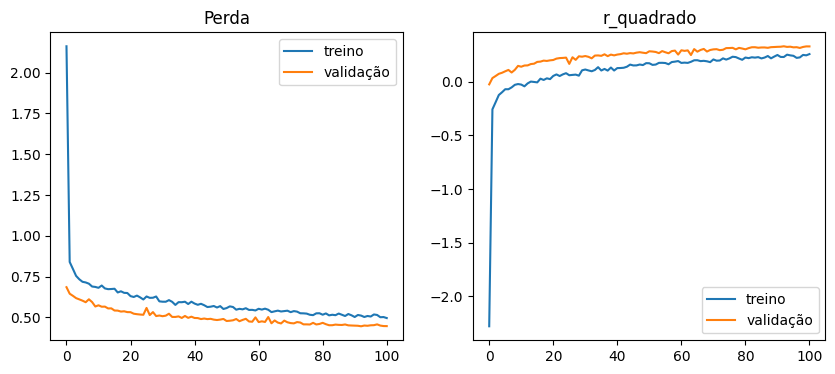

In [ ]:
# faz figura da perda e do r^2 para cada época

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='validação')
plt.title('Perda')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['r_squared'], label='treino')
plt.plot(history.history['val_r_squared'], label='validação')
plt.title('r_quadrado')
plt.legend()
plt.show()

In [ ]:
y_pred_test = model.predict(X_test_s) # predição para o conjunto de teste
y_pred_test = y_pred_test.reshape(1,len(y_pred_test))
r2_score(y_test, y_pred_test[0,:])

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


0.3212602002550017

## melhor resultado até agora

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as B

def r_squared(y_t, y_p):
    SS_res = B.sum(B.square(y_t - y_p))
    SS_tot = B.sum(B.square(y_t - B.mean(y_t)))
    # Adiciona B.epsilon() para evitar divisão por zero
    return (1 - SS_res/(SS_tot + B.epsilon()))

# Construção do modelo no Keras
model = keras.Sequential([
    layers.Input(shape=(X.shape[1],)),

    layers.Dense(150, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(75, activation='relu'),
    layers.Dropout(0.3),
    #layers.Dense(700, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[r_squared])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 150)            │         1,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,201 (51.57 KB)

 Trainable params: 13,201 (51.57 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# treinamento da rede
# verbose = 0, 1 ou 2 indica a quantidade de print
history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=200,
    verbose=1
)

Epoch 1/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.4528 - r_squared: -3.0661 - val_loss: 0.5531 - val_r_squared: 0.0761
Epoch 2/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7223 - r_squared: -0.1694 - val_loss: 0.5297 - val_r_squared: 0.1115
Epoch 3/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6615 - r_squared: -0.1106 - val_loss: 0.5266 - val_r_squared: 0.1191
Epoch 4/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6440 - r_squared: -0.0771 - val_loss: 0.5155 - val_r_squared: 0.1368
Epoch 5/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6556 - r_squared: -0.0858 - val_loss: 0.5036 - val_r_squared: 0.1491
Epoch 6/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6305 - r_squared: -0.0386 - val_loss: 0.4936 - val_r_squared: 0.1677
Epoch 7/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6448 - r_squared: -0.0797 - val_loss: 0.4968 - val_r_squared: 0.1645
Epoch 8/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6062 - r_squa

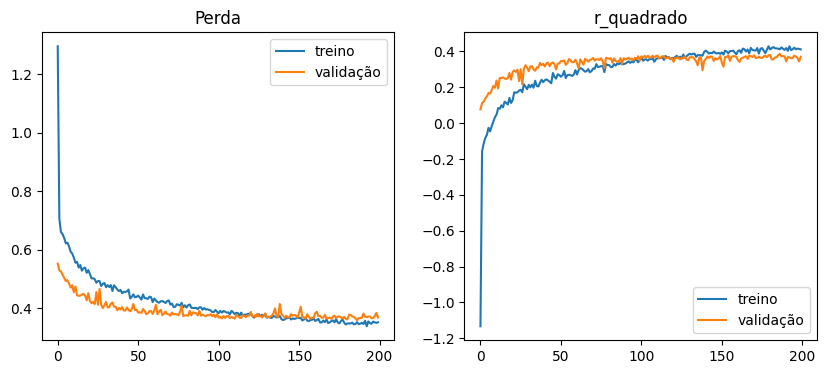

In [ ]:
# faz figura da perda e do r^2 para cada época

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='validação')
plt.title('Perda')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['r_squared'], label='treino')
plt.plot(history.history['val_r_squared'], label='validação')
plt.title('r_quadrado')
plt.legend()
plt.show()

In [ ]:
y_pred_test = model.predict(X_test_s) # predição para o conjunto de teste
y_pred_test = y_pred_test.reshape(1,len(y_pred_test))
r2_score(y_test, y_pred_test[0,:])

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


0.42403509919369053

In [ ]:
# treinamento da rede
# verbose = 0, 1 ou 2 indica a quantidade de print
# aqui são usadas duas estratégias de saída

early_stop = keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor="val_loss")
reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=6, verbose=1, monitor="val_loss")

history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=500,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3305 - r_squared: 0.4662 - val_loss: 0.3629 - val_r_squared: 0.4027 - learning_rate: 0.0010
Epoch 2/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3475 - r_squared: 0.4494 - val_loss: 0.3686 - val_r_squared: 0.3950 - learning_rate: 0.0010
Epoch 3/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3353 - r_squared: 0.4694 - val_loss: 0.3682 - val_r_squared: 0.3956 - learning_rate: 0.0010
Epoch 4/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3493 - r_squared: 0.4429 - val_loss: 0.3656 - val_r_squared: 0.3965 - learning_rate: 0.0010
Epoch 5/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3512 - r_squared: 0.4162 - val_loss: 0.3653 - val_r_squared: 0.4003 - learning_rate: 0.0010
Epoch 6/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3353 - r_squared: 0.4483 - val_loss: 0.3622 - val_r_squared: 0.4016 - learning_rate: 0.0010
Epoch 7/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3379 - r_squared: 0.4

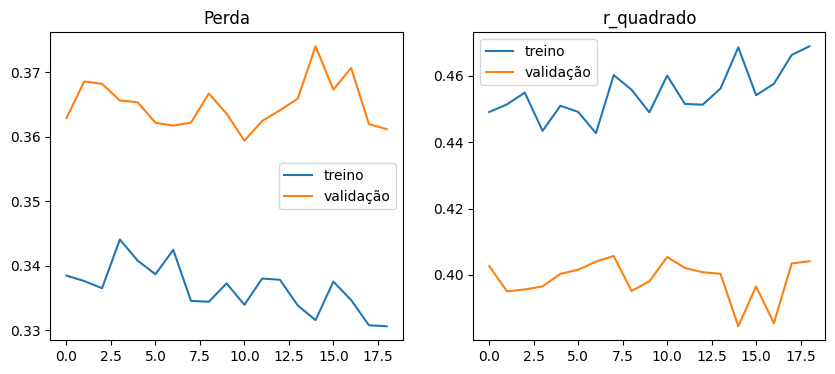

In [ ]:
# faz figura da perda e do r^2 para cada época

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='validação')
plt.title('Perda')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['r_squared'], label='treino')
plt.plot(history.history['val_r_squared'], label='validação')
plt.title('r_quadrado')
plt.legend()
plt.show()

In [ ]:
y_pred_test = model.predict(X_test_s) # predição para o conjunto de teste
y_pred_test = y_pred_test.reshape(1,len(y_pred_test))
r2_score(y_test, y_pred_test[0,:])

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


0.443283119715721

## melhor resultado até agora  - usando MAE

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as B

def r_squared(y_t, y_p):
    SS_res = B.sum(B.square(y_t - y_p))
    SS_tot = B.sum(B.square(y_t - B.mean(y_t)))
    # Adiciona B.epsilon() para evitar divisão por zero
    return (1 - SS_res/(SS_tot + B.epsilon()))

# Construção do modelo no Keras
model = keras.Sequential([
    layers.Input(shape=(X.shape[1],)),

    layers.Dense(150, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(75, activation='relu'),
    layers.Dropout(0.3),
    #layers.Dense(700, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mae',
              metrics=[r_squared])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 150)            │         1,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,201 (51.57 KB)

 Trainable params: 13,201 (51.57 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# treinamento da rede
# verbose = 0, 1 ou 2 indica a quantidade de print
history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=300,
    verbose=1
)

Epoch 1/300
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.2459 - r_squared: -3.2806 - val_loss: 0.5998 - val_r_squared: 0.0401
Epoch 2/300
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6667 - r_squared: -0.1492 - val_loss: 0.5940 - val_r_squared: 0.0491
Epoch 3/300
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6570 - r_squared: -0.1018 - val_loss: 0.5924 - val_r_squared: 0.0459
Epoch 4/300
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6488 - r_squared: -0.0668 - val_loss: 0.5747 - val_r_squared: 0.1190
Epoch 5/300
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6403 - r_squared: -0.0309 - val_loss: 0.5744 - val_r_squared: 0.1568
Epoch 6/300
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6494 - r_squared: -0.0556 - val_loss: 0.5634 - val_r_squared: 0.1580
Epoch 7/300
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6271 - r_squared: -0.0216 - val_loss: 0.5596 - val_r_squared: 0.1577
Epoch 8/300
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6272 - r_squa

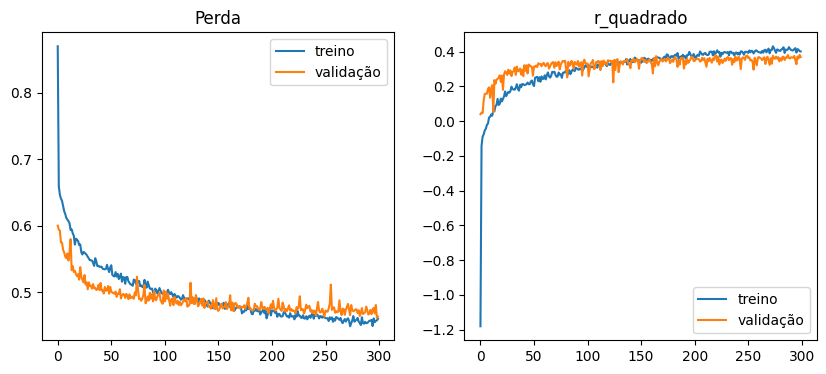

In [ ]:
# faz figura da perda e do r^2 para cada época

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='validação')
plt.title('Perda')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['r_squared'], label='treino')
plt.plot(history.history['val_r_squared'], label='validação')
plt.title('r_quadrado')
plt.legend()
plt.show()

In [ ]:
y_pred_test = model.predict(X_test_s) # predição para o conjunto de teste
y_pred_test = y_pred_test.reshape(1,len(y_pred_test))
r2_score(y_test, y_pred_test[0,:])

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


0.4285008739001174

In [ ]:
# treinamento da rede
# verbose = 0, 1 ou 2 indica a quantidade de print
# aqui são usadas duas estratégias de saída

early_stop = keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor="val_loss")
reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=6, verbose=1, monitor="val_loss")

history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=500,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4500 - r_squared: 0.4491 - val_loss: 0.4670 - val_r_squared: 0.3885 - learning_rate: 0.0010
Epoch 2/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4414 - r_squared: 0.4503 - val_loss: 0.4663 - val_r_squared: 0.3827 - learning_rate: 0.0010
Epoch 3/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4412 - r_squared: 0.4431 - val_loss: 0.4644 - val_r_squared: 0.3895 - learning_rate: 0.0010
Epoch 4/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4405 - r_squared: 0.4487 - val_loss: 0.4653 - val_r_squared: 0.3994 - learning_rate: 0.0010
Epoch 5/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4411 - r_squared: 0.4455 - val_loss: 0.4644 - val_r_squared: 0.3874 - learning_rate: 0.0010
Epoch 6/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4562 - r_squared: 0.4269 - val_loss: 0.4651 - val_r_squared: 0.3912 - learning_rate: 0.0010
Epoch 7/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4432 - r_squared: 0.4

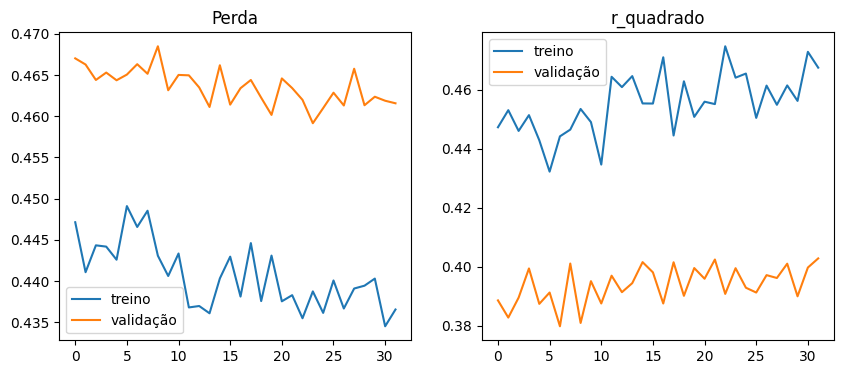

In [ ]:
# faz figura da perda e do r^2 para cada época

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='validação')
plt.title('Perda')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['r_squared'], label='treino')
plt.plot(history.history['val_r_squared'], label='validação')
plt.title('r_quadrado')
plt.legend()
plt.show()

In [ ]:
y_pred_test = model.predict(X_test_s) # predição para o conjunto de teste
y_pred_test = y_pred_test.reshape(1,len(y_pred_test))
r2_score(y_test, y_pred_test[0,:])

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


0.44450147041615506

## Novos testes


### Teste 1 (rede mais burrinha)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as B

def r_squared(y_t, y_p):
    SS_res = B.sum(B.square(y_t - y_p))
    SS_tot = B.sum(B.square(y_t - B.mean(y_t)))
    # Adiciona B.epsilon() para evitar divisão por zero
    return (1 - SS_res/(SS_tot + B.epsilon()))

# Construção do modelo no Keras
model = keras.Sequential([
    layers.Input(shape=(X.shape[1],)),

    layers.Dense(100, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(70, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(50, activation='relu'),
    layers.Dropout(0.3),
    #layers.Dense(700, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[r_squared])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 100)            │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 70)             │         7,070 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 50)             │         3,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,871 (46.37 KB)

 Trainable params: 11,871 (46.37 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# treinamento da rede
# verbose = 0, 1 ou 2 indica a quantidade de print
history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=200,
    verbose=1
)

Epoch 1/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 2.4967 - r_squared: -3.1577 - val_loss: 0.5696 - val_r_squared: 0.0500
Epoch 2/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.8023 - r_squared: -0.3762 - val_loss: 0.5777 - val_r_squared: 0.0378
Epoch 3/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7743 - r_squared: -0.3174 - val_loss: 0.5239 - val_r_squared: 0.1198
Epoch 4/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7545 - r_squared: -0.2503 - val_loss: 0.5428 - val_r_squared: 0.0954
Epoch 5/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7033 - r_squared: -0.1611 - val_loss: 0.5293 - val_r_squared: 0.1182
Epoch 6/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7209 - r_squared: -0.1605 - val_loss: 0.4858 - val_r_squared: 0.1820
Epoch 7/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.6755 - r_squared: -0.1165 - val_loss: 0.4906 - val_r_squared: 0.1801
Epoch 8/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6671 - r_s

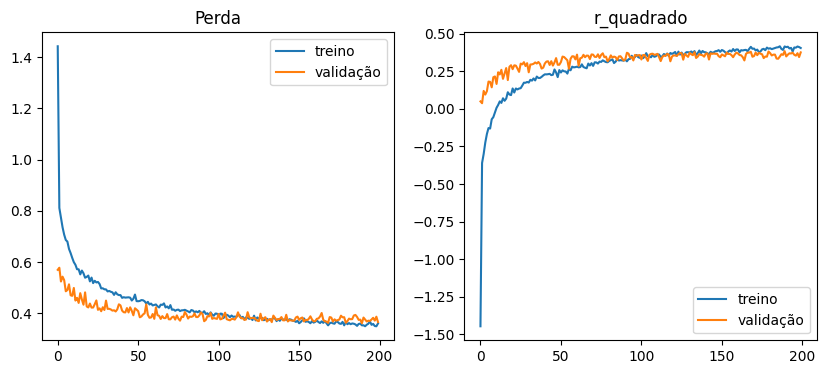

In [ ]:
# faz figura da perda e do r^2 para cada época

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='validação')
plt.title('Perda')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['r_squared'], label='treino')
plt.plot(history.history['val_r_squared'], label='validação')
plt.title('r_quadrado')
plt.legend()
plt.show()

In [ ]:
y_pred_test = model.predict(X_test_s) # predição para o conjunto de teste
y_pred_test = y_pred_test.reshape(1,len(y_pred_test))
r2_score(y_test, y_pred_test[0,:])

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


0.42639955820254294

In [ ]:
# treinamento da rede
# verbose = 0, 1 ou 2 indica a quantidade de print
# aqui são usadas duas estratégias de saída

early_stop = keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor="val_loss")
reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=6, verbose=1, monitor="val_loss")

history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=500,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3438 - r_squared: 0.4221 - val_loss: 0.3640 - val_r_squared: 0.4065 - learning_rate: 0.0010
Epoch 2/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3436 - r_squared: 0.4312 - val_loss: 0.3731 - val_r_squared: 0.3864 - learning_rate: 0.0010
Epoch 3/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3312 - r_squared: 0.4506 - val_loss: 0.3690 - val_r_squared: 0.3943 - learning_rate: 0.0010
Epoch 4/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3492 - r_squared: 0.4274 - val_loss: 0.3704 - val_r_squared: 0.3904 - learning_rate: 0.0010
Epoch 5/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3411 - r_squared: 0.4429 - val_loss: 0.3705 - val_r_squared: 0.3906 - learning_rate: 0.0010
Epoch 6/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3372 - r_squared: 0.4319 - val_loss: 0.3738 - val_r_squared: 0.3899 - learning_rate: 0.0010
Epoch 7/500
44/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3480 - r_squared: 0.4

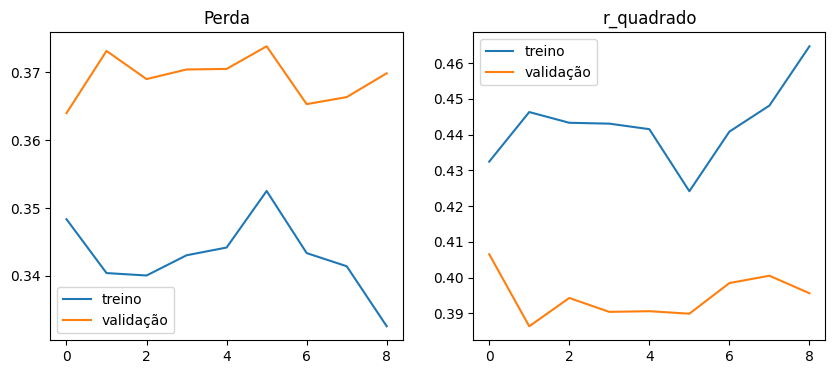

In [ ]:
# faz figura da perda e do r^2 para cada época

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='validação')
plt.title('Perda')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['r_squared'], label='treino')
plt.plot(history.history['val_r_squared'], label='validação')
plt.title('r_quadrado')
plt.legend()
plt.show()

In [ ]:
y_pred_test = model.predict(X_test_s) # predição para o conjunto de teste
y_pred_test = y_pred_test.reshape(1,len(y_pred_test))
r2_score(y_test, y_pred_test[0,:])

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


0.44351860483912753

### Teste 2 (n_neuronios ~ dimensão do treino)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as B

def r_squared(y_t, y_p):
    SS_res = B.sum(B.square(y_t - y_p))
    SS_tot = B.sum(B.square(y_t - B.mean(y_t)))
    # Adiciona B.epsilon() para evitar divisão por zero
    return (1 - SS_res/(SS_tot + B.epsilon()))

# Construção do modelo no Keras
model = keras.Sequential([
    layers.Input(shape=(X.shape[1],)),

    layers.Dense(3000, activation='relu'),
    layers.Dropout(0.3),
    #layers.Dense(700, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[r_squared])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 3000)           │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 3000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │         3,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,001 (152.35 KB)

 Trainable params: 39,001 (152.35 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# treinamento da rede
# verbose = 0, 1 ou 2 indica a quantidade de print
history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=200,
    verbose=1
)

Epoch 1/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 1.6865 - r_squared: -1.5652 - val_loss: 0.5410 - val_r_squared: 0.0924
Epoch 2/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.5490 - r_squared: 0.0520 - val_loss: 0.5366 - val_r_squared: 0.1024
Epoch 3/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.5524 - r_squared: 0.0791 - val_loss: 0.5182 - val_r_squared: 0.1316
Epoch 4/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5354 - r_squared: 0.1116 - val_loss: 0.5202 - val_r_squared: 0.1300
Epoch 5/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.5350 - r_squared: 0.1144 - val_loss: 0.5097 - val_r_squared: 0.1344
Epoch 6/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.5129 - r_squared: 0.1568 - val_loss: 0.4925 - val_r_squared: 0.1733
Epoch 7/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4953 - r_squared: 0.1782 - val_loss: 0.4925 - val_r_squared: 0.1762
Epoch 8/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5048 - r_squa

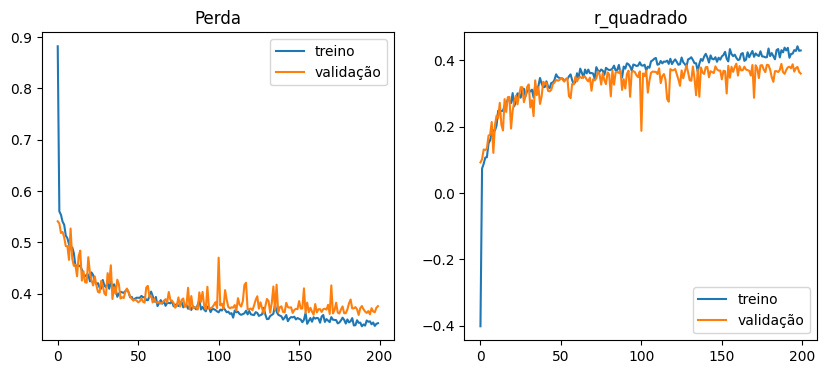

In [ ]:
# faz figura da perda e do r^2 para cada época

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='validação')
plt.title('Perda')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['r_squared'], label='treino')
plt.plot(history.history['val_r_squared'], label='validação')
plt.title('r_quadrado')
plt.legend()
plt.show()

In [ ]:
y_pred_test = model.predict(X_test_s) # predição para o conjunto de teste
y_pred_test = y_pred_test.reshape(1,len(y_pred_test))
r2_score(y_test, y_pred_test[0,:])

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


0.40054452040612354

In [ ]:
# treinamento da rede
# verbose = 0, 1 ou 2 indica a quantidade de print
# aqui são usadas duas estratégias de saída

early_stop = keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor="val_loss")
reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=6, verbose=1, monitor="val_loss")

history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=500,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3096 - r_squared: 0.4909 - val_loss: 0.3621 - val_r_squared: 0.4122 - learning_rate: 0.0010
Epoch 2/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3415 - r_squared: 0.4509 - val_loss: 0.3622 - val_r_squared: 0.4140 - learning_rate: 0.0010
Epoch 3/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3457 - r_squared: 0.4628 - val_loss: 0.3797 - val_r_squared: 0.3819 - learning_rate: 0.0010
Epoch 4/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3299 - r_squared: 0.4654 - val_loss: 0.3610 - val_r_squared: 0.4120 - learning_rate: 0.0010
Epoch 5/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3293 - r_squared: 0.4707 - val_loss: 0.3669 - val_r_squared: 0.4003 - learning_rate: 0.0010
Epoch 6/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3290 - r_squared: 0.4382 - val_loss: 0.3616 - val_r_squared: 0.4099 - learning_rate: 0.0010
Epoch 7/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3151 - r_squared: 0.4

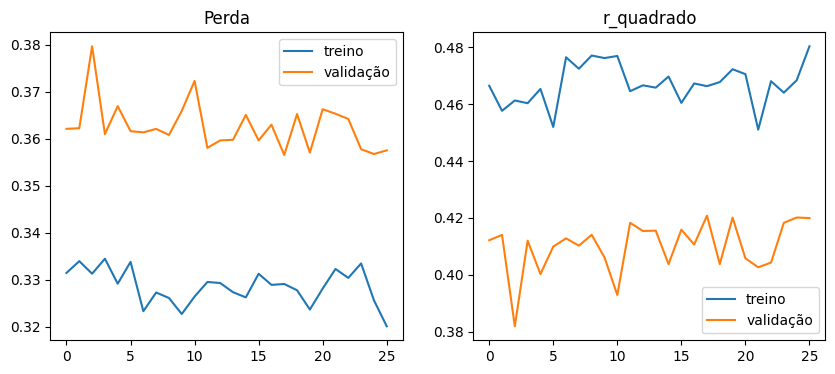

In [ ]:
# faz figura da perda e do r^2 para cada época

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='validação')
plt.title('Perda')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['r_squared'], label='treino')
plt.plot(history.history['val_r_squared'], label='validação')
plt.title('r_quadrado')
plt.legend()
plt.show()

In [ ]:
y_pred_test = model.predict(X_test_s) # predição para o conjunto de teste
y_pred_test = y_pred_test.reshape(1,len(y_pred_test))
r2_score(y_test, y_pred_test[0,:])

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


0.4141539487047625

### Teste 3 (maior r2 para pred mas com overfitting)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as B

def r_squared(y_t, y_p):
    SS_res = B.sum(B.square(y_t - y_p))
    SS_tot = B.sum(B.square(y_t - B.mean(y_t)))
    # Adiciona B.epsilon() para evitar divisão por zero
    return (1 - SS_res/(SS_tot + B.epsilon()))

# Construção do modelo no Keras
model = keras.Sequential([
    layers.Input(shape=(X.shape[1],)),

    layers.Dense(700, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(500, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(200, activation='relu'),
    layers.Dropout(0.3),
    #layers.Dense(700, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[r_squared])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 700)            │         8,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 500)            │       350,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 459,301 (1.75 MB)

 Trainable params: 459,301 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# treinamento da rede
# verbose = 0, 1 ou 2 indica a quantidade de print
history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=200,
    verbose=1
)

Epoch 1/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 1.5074 - r_squared: -1.4862 - val_loss: 0.5218 - val_r_squared: 0.1215
Epoch 2/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.6439 - r_squared: -0.0653 - val_loss: 0.4934 - val_r_squared: 0.1695
Epoch 3/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.5802 - r_squared: -0.0098 - val_loss: 0.4927 - val_r_squared: 0.1758
Epoch 4/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.5910 - r_squared: 0.0371 - val_loss: 0.4714 - val_r_squared: 0.2019
Epoch 5/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5415 - r_squared: 0.0546 - val_loss: 0.5239 - val_r_squared: 0.1033
Epoch 6/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5426 - r_squared: 0.1013 - val_loss: 0.4842 - val_r_squared: 0.1891
Epoch 7/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5386 - r_squared: 0.0942 - val_loss: 0.7880 - val_r_squared: -0.3236
Epoch 8/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5572 - r

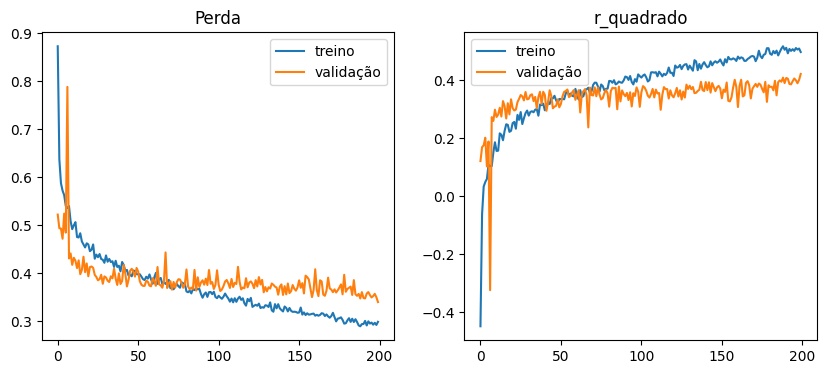

In [ ]:
# faz figura da perda e do r^2 para cada época

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='validação')
plt.title('Perda')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['r_squared'], label='treino')
plt.plot(history.history['val_r_squared'], label='validação')
plt.title('r_quadrado')
plt.legend()
plt.show()

In [ ]:
y_pred_test = model.predict(X_test_s) # predição para o conjunto de teste
y_pred_test = y_pred_test.reshape(1,len(y_pred_test))
r2_score(y_test, y_pred_test[0,:])

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


0.4529679594328294

In [ ]:
# treinamento da rede
# verbose = 0, 1 ou 2 indica a quantidade de print
# aqui são usadas duas estratégias de saída

early_stop = keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor="val_loss")
reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=6, verbose=1, monitor="val_loss")

history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=500,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2682 - r_squared: 0.5506 - val_loss: 0.3430 - val_r_squared: 0.4412 - learning_rate: 0.0010
Epoch 2/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.2856 - r_squared: 0.5486 - val_loss: 0.3522 - val_r_squared: 0.4214 - learning_rate: 0.0010
Epoch 3/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2642 - r_squared: 0.5536 - val_loss: 0.3474 - val_r_squared: 0.4266 - learning_rate: 0.0010
Epoch 4/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2665 - r_squared: 0.5751 - val_loss: 0.3506 - val_r_squared: 0.4278 - learning_rate: 0.0010
Epoch 5/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2849 - r_squared: 0.5384 - val_loss: 0.3531 - val_r_squared: 0.4232 - learning_rate: 0.0010
Epoch 6/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2561 - r_squared: 0.5614 - val_loss: 0.3503 - val_r_squared: 0.4276 - learning_rate: 0.0010
Epoch 7/500
55/58 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2644 - r_squar

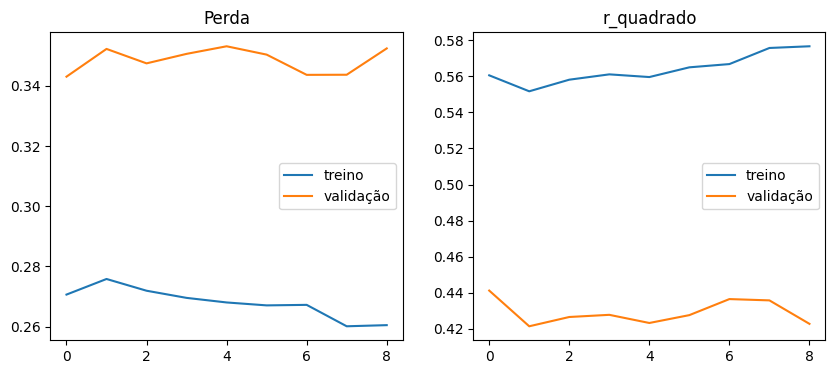

In [ ]:
# faz figura da perda e do r^2 para cada época

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='validação')
plt.title('Perda')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['r_squared'], label='treino')
plt.plot(history.history['val_r_squared'], label='validação')
plt.title('r_quadrado')
plt.legend()
plt.show()

In [ ]:
y_pred_test = model.predict(X_test_s) # predição para o conjunto de teste
y_pred_test = y_pred_test.reshape(1,len(y_pred_test))
r2_score(y_test, y_pred_test[0,:])

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


0.46704496670934936

### Teste 4 (Teste 3 com mais épocas)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as B

def r_squared(y_t, y_p):
    SS_res = B.sum(B.square(y_t - y_p))
    SS_tot = B.sum(B.square(y_t - B.mean(y_t)))
    # Adiciona B.epsilon() para evitar divisão por zero
    return (1 - SS_res/(SS_tot + B.epsilon()))

# Construção do modelo no Keras
model = keras.Sequential([
    layers.Input(shape=(X.shape[1],)),

    layers.Dense(700, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(500, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(200, activation='relu'),
    layers.Dropout(0.3),
    #layers.Dense(700, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[r_squared])

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                │ (None, 700)            │         8,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 500)            │       350,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 459,301 (1.75 MB)

 Trainable params: 459,301 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# treinamento da rede
# verbose = 0, 1 ou 2 indica a quantidade de print
history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=220,
    verbose=1
)

Epoch 1/220
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 1.6530 - r_squared: -1.8062 - val_loss: 0.5255 - val_r_squared: 0.1149
Epoch 2/220
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.6350 - r_squared: -0.0372 - val_loss: 0.5186 - val_r_squared: 0.1349
Epoch 3/220
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.6232 - r_squared: -0.0327 - val_loss: 0.4817 - val_r_squared: 0.1857
Epoch 4/220
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.5581 - r_squared: 0.0670 - val_loss: 0.5074 - val_r_squared: 0.1547
Epoch 5/220
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.5988 - r_squared: 0.0364 - val_loss: 0.4496 - val_r_squared: 0.2465
Epoch 6/220
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.5735 - r_squared: 0.0588 - val_loss: 0.4391 - val_r_squared: 0.2606
Epoch 7/220
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.5426 - r_squared: 0.1104 - val_loss: 0.4838 - val_r_squared: 0.1762
Epoch 8/220
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.5497 - r_

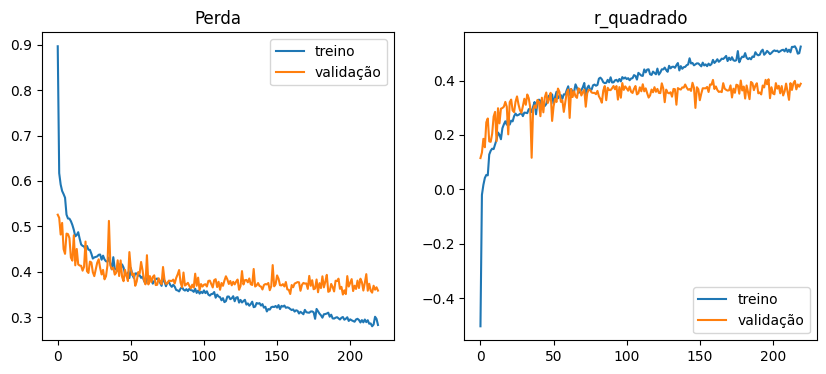

In [ ]:
# faz figura da perda e do r^2 para cada época

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='validação')
plt.title('Perda')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['r_squared'], label='treino')
plt.plot(history.history['val_r_squared'], label='validação')
plt.title('r_quadrado')
plt.legend()
plt.show()

In [ ]:
y_pred_test = model.predict(X_test_s) # predição para o conjunto de teste
y_pred_test = y_pred_test.reshape(1,len(y_pred_test))
r2_score(y_test, y_pred_test[0,:])

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


0.45819487874845743

### Teste 5 (Teste 3 com menos épocas)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as B

def r_squared(y_t, y_p):
    SS_res = B.sum(B.square(y_t - y_p))
    SS_tot = B.sum(B.square(y_t - B.mean(y_t)))
    # Adiciona B.epsilon() para evitar divisão por zero
    return (1 - SS_res/(SS_tot + B.epsilon()))

# Construção do modelo no Keras
model = keras.Sequential([
    layers.Input(shape=(X.shape[1],)),

    layers.Dense(700, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(500, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(200, activation='relu'),
    layers.Dropout(0.3),
    #layers.Dense(700, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[r_squared])

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 700)            │         8,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 500)            │       350,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 459,301 (1.75 MB)

 Trainable params: 459,301 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# treinamento da rede
# verbose = 0, 1 ou 2 indica a quantidade de print
history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=100,
    verbose=1
)

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 1.5638 - r_squared: -1.5233 - val_loss: 0.5380 - val_r_squared: 0.0897
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.6220 - r_squared: 9.6682e-04 - val_loss: 0.5281 - val_r_squared: 0.1195
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.5882 - r_squared: -0.0106 - val_loss: 0.5285 - val_r_squared: 0.1175
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.5830 - r_squared: 0.0413 - val_loss: 0.5106 - val_r_squared: 0.1485
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.5493 - r_squared: 0.1190 - val_loss: 0.5211 - val_r_squared: 0.1298
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.5554 - r_squared: 0.1112 - val_loss: 0.4355 - val_r_squared: 0.2659
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.5505 - r_squared: 0.1023 - val_loss: 0.5150 - val_r_squared: 0.1397
Epoch 8/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.4973 -

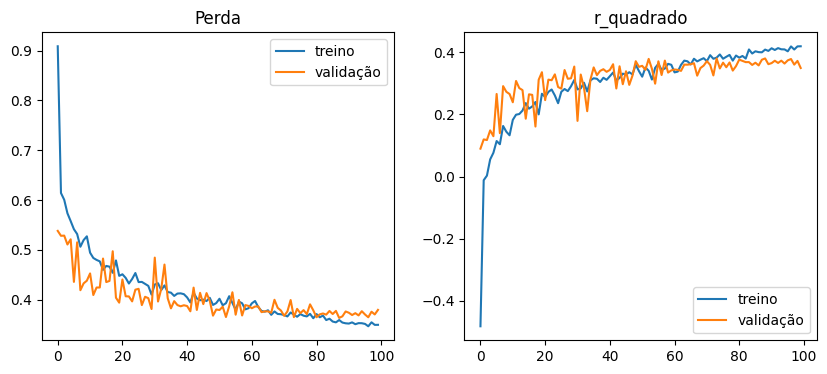

In [ ]:
# faz figura da perda e do r^2 para cada época

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='validação')
plt.title('Perda')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['r_squared'], label='treino')
plt.plot(history.history['val_r_squared'], label='validação')
plt.title('r_quadrado')
plt.legend()
plt.show()

In [ ]:
y_pred_test = model.predict(X_test_s) # predição para o conjunto de teste
y_pred_test = y_pred_test.reshape(1,len(y_pred_test))
r2_score(y_test, y_pred_test[0,:])

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


0.4328406530163267

### Teste 6 (Teste 5 com menos drop)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as B

def r_squared(y_t, y_p):
    SS_res = B.sum(B.square(y_t - y_p))
    SS_tot = B.sum(B.square(y_t - B.mean(y_t)))
    # Adiciona B.epsilon() para evitar divisão por zero
    return (1 - SS_res/(SS_tot + B.epsilon()))

# Construção do modelo no Keras
model = keras.Sequential([
    layers.Input(shape=(X.shape[1],)),

    layers.Dense(700, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(500, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(200, activation='relu'),
    layers.Dropout(0.25),
    #layers.Dense(700, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[r_squared])

model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_34 (Dense)                │ (None, 700)            │         8,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 500)            │       350,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 459,301 (1.75 MB)

 Trainable params: 459,301 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# treinamento da rede
# verbose = 0, 1 ou 2 indica a quantidade de print
history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=100,
    verbose=1
)

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 1.4326 - r_squared: -1.4508 - val_loss: 0.5996 - val_r_squared: 0.0018
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.6521 - r_squared: -0.0617 - val_loss: 0.5370 - val_r_squared: 0.1016
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.6243 - r_squared: -0.0430 - val_loss: 0.4744 - val_r_squared: 0.1980
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.5607 - r_squared: 0.0662 - val_loss: 0.4558 - val_r_squared: 0.2301
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.5189 - r_squared: 0.1634 - val_loss: 0.4634 - val_r_squared: 0.2218
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.5329 - r_squared: 0.0915 - val_loss: 0.4637 - val_r_squared: 0.2213
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.5079 - r_squared: 0.1429 - val_loss: 0.4195 - val_r_squared: 0.2924
Epoch 8/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.4872 - r_

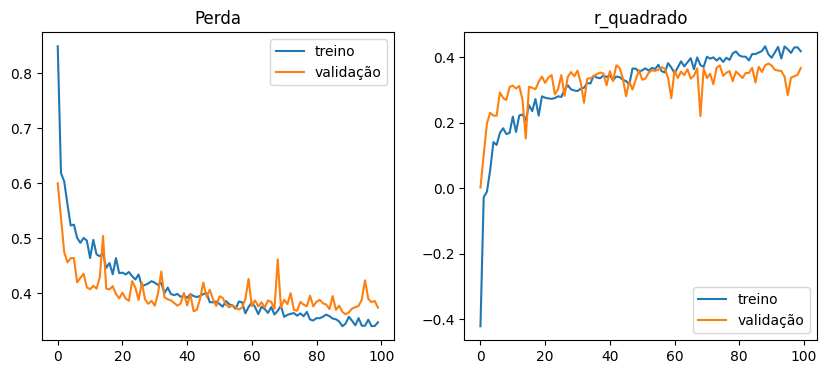

In [ ]:
# faz figura da perda e do r^2 para cada época

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='validação')
plt.title('Perda')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['r_squared'], label='treino')
plt.plot(history.history['val_r_squared'], label='validação')
plt.title('r_quadrado')
plt.legend()
plt.show()

In [ ]:
y_pred_test = model.predict(X_test_s) # predição para o conjunto de teste
y_pred_test = y_pred_test.reshape(1,len(y_pred_test))
r2_score(y_test, y_pred_test[0,:])

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


0.42898994799384405

### Teste 7 (Teste 5 com mais drop)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as B

def r_squared(y_t, y_p):
    SS_res = B.sum(B.square(y_t - y_p))
    SS_tot = B.sum(B.square(y_t - B.mean(y_t)))
    # Adiciona B.epsilon() para evitar divisão por zero
    return (1 - SS_res/(SS_tot + B.epsilon()))

# Construção do modelo no Keras
model = keras.Sequential([
    layers.Input(shape=(X.shape[1],)),

    layers.Dense(700, activation='relu'),
    layers.Dropout(0.35),
    layers.Dense(500, activation='relu'),
    layers.Dropout(0.35),
    layers.Dense(200, activation='relu'),
    layers.Dropout(0.35),
    #layers.Dense(700, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[r_squared])

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_38 (Dense)                │ (None, 700)            │         8,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 500)            │       350,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 459,301 (1.75 MB)

 Trainable params: 459,301 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# treinamento da rede
# verbose = 0, 1 ou 2 indica a quantidade de print
history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=100,
    verbose=1
)

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 1.4595 - r_squared: -1.3677 - val_loss: 0.6134 - val_r_squared: -0.0224
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.6846 - r_squared: -0.1202 - val_loss: 0.5299 - val_r_squared: 0.0977
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.6392 - r_squared: -0.0359 - val_loss: 0.4867 - val_r_squared: 0.1806
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.6123 - r_squared: 0.0235 - val_loss: 0.4637 - val_r_squared: 0.2228
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.5759 - r_squared: 0.0362 - val_loss: 0.4559 - val_r_squared: 0.2344
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.5498 - r_squared: 0.0748 - val_loss: 0.4400 - val_r_squared: 0.2616
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.5547 - r_squared: 0.0783 - val_loss: 0.4467 - val_r_squared: 0.2441
Epoch 8/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.5258 - 

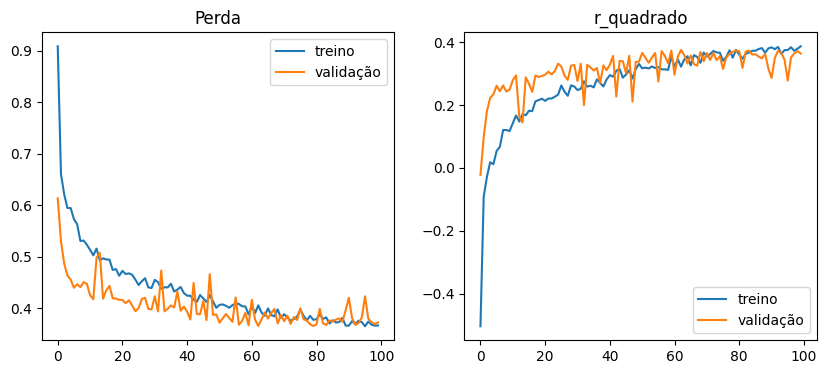

In [ ]:
# faz figura da perda e do r^2 para cada época

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='validação')
plt.title('Perda')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['r_squared'], label='treino')
plt.plot(history.history['val_r_squared'], label='validação')
plt.title('r_quadrado')
plt.legend()
plt.show()

In [ ]:
y_pred_test = model.predict(X_test_s) # predição para o conjunto de teste
y_pred_test = y_pred_test.reshape(1,len(y_pred_test))
r2_score(y_test, y_pred_test[0,:])

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


0.42801645755297624